# Build the LLaMA 3 Architecture from Scratch Using PyTorch

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple, List
from tqdm import tqdm

In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')

# 1 - The Input Block

The input to the model should always be in number format as it is unable to process text. Tokenizer helps to convert these texts/prompts into token-ids (which is an index number representation of tokens in vocabulary). We'll be using a character-level tokenizer for our model building.

In [4]:
class InputBlock(nn.Module):
    """
    Embeds a batch of token_ids generated from texts or prompts using tokenizers.
    """

    def __init__(self, vocab_size:int, embed_dim:int) -> None:
        super(InputBlock, self).__init__()
        # init embedding class from the input block
        self.embeddings= nn.Embedding(vocab_size, embed_dim)


    def forward(self, x):
        h= self.embeddings(x)

        return h # x[bsz,seq_len] -> h[bsz,seq_len,embed_dim]


# 2 - The Decoder Block

The embedding vector has many dimensions (4096 dim in LLaMA 3-8B) and there is always a chance of having values in different ranges. This can cause model gradients to explode or vanish hence resulting in slow convergence or even divergence.

# 2.1 - RMSNorm

The **RMSNorm** brings these values into a certain range which helps to stabilize and accelerate the training process. This makes gradients have more consistent magnitudes and that results in making models converge more quickly.

$$\hat{a}_i = \frac{a_i}{RMS(a)}g_i \text{, where } RMS(a) = \sqrt{\frac{1}{n}\sum_{i=1}^n{a_i^2}}$$

Specifically, Pre-normalization using RMSNorm helps LLMs prioritize which parts of the text are more critical for understanding the context and meaning. It assigns higher weights to essential elements and lower weights to less crucial ones, ensuring the model focuses its attention where it's most needed for accurate comprehension.

In [5]:
class RMSNorm(nn.Module):
    """
    Root Mean Square normalization (RMSNorm).
    """

    def __init__(self, dim:int, eps:float=1e-6) -> None:
        super(RMSNorm, self).__init__()
        # scaling parameter gamma initialized with ones and the amount of parameters equal to dim
        self.gamma= nn.Parameter(torch.ones(dim))
        self.eps= eps


    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)


    def forward(self, x):
        x_norm= self._norm(x.float()).type_as(x) # x[bs,seq,dim] -> x_norm[bs,seq,dim]

        return x_norm * self.gamma


In [6]:
# -- Test: RMSNorm Code --
x= torch.randn((10, 256, 512), device=device)
rms_norm= RMSNorm(512).to(device)
x_norm= rms_norm(x)

print(f"Shape of x: {x.shape}")
print(f"Shape of x_norm: {x_norm.shape}")

Shape of x: torch.Size([10, 256, 512])
Shape of x_norm: torch.Size([10, 256, 512])


# 2.2 - RoPE

**Rotary Positional Encoding (RoPE):** Let's say the input text is "I love apple" or "apple love I", the model will still treat both sentences as the same and learn it as the same. Because there is no order defined in the embeddings for the model to learn. Hence, the order is very important for any language model. In LLaMA 3 model architecture, RoPE is used to define the position of each token in the sentences that maintain not only the order but also maintains the relative position of tokens in the sentences.

So, what is Rotary Positional Encoding and how does it work? As mentioned in the why section above, RoPE is a type of position encoding that encodes the embeddings which maintains the order of tokens in the sentences by adding absolute positional information as well as incorporates the relative position information among the tokens. It performs the encoding action by rotating a given embedding by a special matrix called the rotation matrix. This simple yet very powerful mathematical derivation using rotation matrix is the heart of RoPE.

**Note:** the rotation matrix needs to be converted to polar form and the embedding vector needs to converted to complex before performing rotation. After rotation is completed, the rotated embeddings need to be converted back to real for attention operation. Also, RoPE is applied to Query and Key embedding only. It doesn't apply to Value embedding.

In [7]:
class QK_RoPE(nn.Module):
    """
    Define Rotary Positional Encoding (RoPE) functions for Query and Key embeddings.
    """

    def __init__(self, head_dim:int, max_seq_len:int, theta:float=10000.0) -> None:
        super(QK_RoPE, self).__init__()
        assert head_dim % 2 == 0, "head_dim must be even for RoPE"
        self.head_dim= head_dim
        self.max_seq_len= max_seq_len
        self.theta= theta
        self.device= None


    def precompute_freqs_cis(self, dim, max_len):
        # computing theta value for each dim pair which is dim/2
        freqs= 1.0 / (self.theta ** (
            torch.arange(0, dim, 2, device=self.device)[: (dim // 2)].float() / dim
        ))
        # computing range of positions(m) in the sequence
        t= torch.arange(max_len, dtype=torch.float32, device=self.device)
        # freqs gives all the theta value range for all the position of tokens in the sequence
        freqs= torch.outer(t, freqs).to(self.device)
        # the rotation matrix needs to be converted to Polar coordinates form in order to perform
        # rotation to embedding
        freqs_cis= torch.polar(torch.ones_like(freqs).to(self.device), freqs).to(self.device)

        return freqs_cis


    def reshape_for_broadcast(self, freqs_cis, x):
        ndim= x.ndim
        assert 0<= 1< ndim
        assert freqs_cis.shape== (x.shape[1], x.shape[-1]), "The last two dimension of freqs_cis and x must match"
        shape= [d if i==1 or i==ndim-1 else 1 for i,d in enumerate(x.shape)]

        return freqs_cis.view(*shape)


    def forward(self, q, k, start_pos, inference) -> Tuple[torch.Tensor, torch.Tensor]:
        if self.device is None:
            self.device= q.device

        bsz, seq_len, _, _= q.shape

        if inference:
            # compute rotation matrix for each position in the sequence
            freqs_cis= self.precompute_freqs_cis(self.head_dim, self.max_seq_len * 2)
            # during inference we should only take the rotation matrix range from the current
            # position of the tokens
            freqs_cis= freqs_cis[start_pos : start_pos + seq_len]
        else:
            # compute rotation matrix to query and key for training
            freqs_cis= self.precompute_freqs_cis(self.head_dim, self.max_seq_len)

        """
        Applying rotary positional encoding to both query and key embedding together.
        - First: The last dimension of q and k embedding needs to be reshaped to make it a
        pair. As rotation matrix is applied to each pair of dim.
        - Next: convert both q and k to complex number as the rotation matrix is only
        applicable to complex number.
        """
        # q/k_ci[bsz,seq_len,n_heads,head_dim/2]
        q_ci= torch.view_as_complex(q.float().reshape(*q.shape[:-1], -1, 2)).to(self.device)
        k_ci= torch.view_as_complex(k.float().reshape(*k.shape[:-1], -1, 2)).to(self.device)

        """
        The rotation matrix(freqs_cis) dimensions across seq_len(dim=1) and head_dim(dim=3) should
        match with the embedding. Also, the shape freqs_cis should be the same with q and k,
        hence change the shape of freqs_cis: [seq_len, head_dim] -> freqs_cis: [1, seq_len, 1, head_dim]
        """
        freqs_cis= self.reshape_for_broadcast(freqs_cis, q_ci)

        """
        Finally, perform rotation operation by multiplying with freqs_cis.
        After the rotation is completed, convert both q_out and k_out back to real number and return.
        """
        # q/k_out[bsz,seq_len,n_heads,head_dim]
        q_out= torch.view_as_real(q_ci * freqs_cis).flatten(3).to(self.device)
        k_out= torch.view_as_real(k_ci * freqs_cis).flatten(3).to(self.device)

        return q_out.type_as(q), k_out.type_as(k)


In [8]:
# -- Test: RoPE Code --
# Note: x_norm is calculated during RMSNorm and is being used for testing here
head_dim= 512//8
rope= QK_RoPE(head_dim, 256).to(device)

wq= nn.Linear(512, 8 * head_dim, bias=False).to(device)
wk= nn.Linear(512, 4 * head_dim, bias=False).to(device)
xq= wq(x_norm)
xk= wk(x_norm)
print(f"xq.shape: {xq.shape}")
print(f"xk.shape: {xk.shape}")

xq= xq.view(xq.shape[0],xq.shape[1], 8, head_dim)
xk= xk.view(xk.shape[0],xk.shape[1], 4, head_dim)
print(f"xq.re-shape: {xq.shape}")
print(f"xk.re-shape: {xk.shape}")

freqs_cis= rope.precompute_freqs_cis(dim=head_dim, max_len=256)
print(f"freqs_cis.shape: {freqs_cis.shape}")

xq_rotate, xk_rotate= rope(xq, xk, 0, False)
print(f"xq_rotate.shape: {xq_rotate.shape}")
print(f"xk_rotate.shape: {xk_rotate.shape}")

xq.shape: torch.Size([10, 256, 512])
xk.shape: torch.Size([10, 256, 256])
xq.re-shape: torch.Size([10, 256, 8, 64])
xk.re-shape: torch.Size([10, 256, 4, 64])
freqs_cis.shape: torch.Size([256, 32])
xq_rotate.shape: torch.Size([10, 256, 8, 64])
xk_rotate.shape: torch.Size([10, 256, 4, 64])


# 2.3 - KV Cache

**KV Cache (Only required at Inferencing):** In LLaMA 3 architecture, at the time of inferencing, the concept of KV-Cache is introduced to store previously generated tokens in the form of Key and Value cache. These caches will be used to calculate self-attention to generate the next token. Only key and value tokens are cached whereas query tokens are not cached, hence the term KV Cache.

In [9]:
class KV_Cache(nn.Module):
    """
    KV Cache Implementation.
    """

    def __init__(self, max_batch_size:int, max_seq_len:int, n_kv_heads:int, head_dim:int) -> None:
        super(KV_Cache, self).__init__()
        self.device= None
        # initialize caches to store Key, Value at start
        self.cache_k= torch.zeros((max_batch_size, max_seq_len, n_kv_heads, head_dim))
        self.cache_v= torch.zeros((max_batch_size, max_seq_len, n_kv_heads, head_dim))


    def cache_invalidation(self, batch_idx=None):

        if batch_idx is None:
            # invalidate the entire cache
            self.cache_k.zero_()
            self.cache_v.zero_()
        else:
            # invalidate only the cache for the given batch_idx
            self.cache_k[batch_idx].zero_()
            self.cache_v[batch_idx].zero_()


    def forward(self, q, k, v, start_pos):
        if self.device is None:
            self.device = q.device
            self.cache_k= self.cache_k.to(self.device)
            self.cache_v= self.cache_v.to(self.device)

        bsz, seq_len, _, _= v.shape

        self.cache_k= self.cache_k.to(q)
        self.cache_v= self.cache_v.to(q)
        # store Key and Value token embeddings into their respective caches
        self.cache_k[:bsz, start_pos : start_pos + seq_len]= k
        self.cache_v[:bsz, start_pos : start_pos + seq_len]= v
        # assign all the previous tokens embeddings upto current tokens position to Key and
        # Value variable for Attention calculation
        key  = self.cache_k[:bsz, : start_pos + seq_len]
        value= self.cache_v[:bsz, : start_pos + seq_len]

        return key, value


In [ ]:
# https://towardsdatascience.com/transformers-key-value-kv-caching-explained-4d71de62d22d

# 2.4 - Group Query Attention

**Group Query Attention** is the same as Muilt-Head Attention which was used in previous models such as LLaMA 1 with the only difference being in the use of separate heads for query and separate heads for key/value. Usually, the number of heads assigned to query is n-times to that of key, and value heads.

Since Multi-Head Attention is already so good, why do we need Group query attention? To answer this, we need to go back to KV Cache for a while. The KV cache helps reduce computation resources greatly. However, as KV Cache stores more and more previous tokens, the memory resources will increase significantly. This is not a good thing for the model performance point of view as well as the financial point of view. Hence, Group query attention is introduced.

Reducing the number of heads for K and V decreases the number of parameters to be stored, and hence, less memory is being used. Various test results have proven that the model accuracy remains in the same ranges with this approach.

In [10]:
class MultiHeadedSelfAttention(nn.Module):
    """
    The Group Query Self Attention Block [RoPE, KV Cache, and Group Query Attention].
    """

    def __init__(self, dim:int, n_heads:int, n_kv_heads:int, max_batch_size:int,
                 max_seq_len:int, rope_theta=10000.0) -> None:
        super(MultiHeadedSelfAttention, self).__init__()
        assert dim % n_heads == 0, "model dim must be divisible by n_heads"
        # embedding dimension
        self.dim= dim
        # number of heads assigned to Query
        self.n_heads= n_heads
        # number of heads assigned to Key and Value. If None, the number will be same as Query
        self.n_kv_heads= n_heads if n_kv_heads is None else n_kv_heads
        # dimension of each head relative to model dimension
        self.head_dim= dim // n_heads
        # number of repetition in order to make time Key, Value heads to match Query heads number
        self.n_rep= n_heads // n_kv_heads

        # initialize Query, Key, Value and Oupt
        # notice that the out_feature value of weight for q and kv are based on it's heads
        self.q_proj= nn.Linear(dim,    n_heads * self.head_dim, bias=False)
        self.k_proj= nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.v_proj= nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.o_proj= nn.Linear(n_heads * self.head_dim,    dim, bias=False)
        # initialize Rotary Positional Encoding
        self.rotary_emb= QK_RoPE(self.head_dim, max_seq_len, rope_theta)
        # initialize KV Cache to store Key and Value
        self.kv_cache= KV_Cache(max_batch_size, max_seq_len, n_kv_heads, self.head_dim)


    def repeat_kv(self, x, n_rep):
        # if the number of key/value heads is less than query heads, this function expands the
        # key/value embeddings with the required number of repetition
        bsz, seq_len, n_kv_heads, head_dim= x.shape

        if n_rep== 1:
            return x

        return (
            x[:,:,:,None,:]
             .expand(bsz, seq_len,  n_kv_heads,  n_rep,  head_dim)
            .reshape(bsz, seq_len, (n_kv_heads * n_rep), head_dim)
        )


    def forward(self, x, start_pos, inference=True):
        bsz, seq_len, dim= x.shape  # shape of the input embedding: [bsz, seq_len, dim]
        assert dim == self.dim, "Input embedding dimension must match model embedding dimension"
        # mask will be used during 'Training' and not for 'Inference' due to the use of KV cache
        mask= None

        q= self.q_proj(x) # x[bsz,seq_len,dim]*wq[dim,   n_heads*head_dim] -> q[bsz,seq_len,   n_heads*head_dim]
        k= self.k_proj(x) # x[bsz,seq_len,dim]*wk[dim,n_kv_heads*head_dim] -> k[bsz,seq_len,n_kv_heads*head_dim]
        v= self.v_proj(x) # x[bsz,seq_len,dim]*wv[dim,n_kv_heads*head_dim] -> v[bsz,seq_len,n_kv_heads*head_dim]
        # reshaping Query, Key and Value by their number of heads
        # (Group Query Attention Implementation)
        q= q.view(bsz, seq_len, self.n_heads,    self.head_dim)
        k= k.view(bsz, seq_len, self.n_kv_heads, self.head_dim)
        v= v.view(bsz, seq_len, self.n_kv_heads, self.head_dim)

        # apply RoPE to Query and Key embeddings
        q, k= self.rotary_emb(q, k, start_pos, inference)

        if inference:
        # ----- Inference Mode: KV-Cache is enabled at inference mode only -----
            k, v= self.kv_cache(q, k, v, start_pos)
        else:
        # ----- Training mode: KV-Cache is not enabled and the triangular masking is enabled -----
            # performs Masked Attention on the outputs, so that positions depend on the past only
            # create a lower triangular matrix (2-D tensor)
            mask= torch.tril(torch.ones((seq_len, seq_len), device=x.device)).view(1, 1, seq_len, seq_len)

        # at this point, Key and Value shapes aren't same with Query embedding which has to be
        # in order to computer Attention scores
        # use repeat_kv function to make Key/Value shape same as Query shape
        k= self.repeat_kv(k, self.n_rep) # k[bsz,seq_len,n_heads,head_dim]
        v= self.repeat_kv(v, self.n_rep) # v[bsz,seq_len,n_heads,head_dim]

        # to compute Attention, we'll need to perform a transpose operation to reshape all
        # Query, Key, and Value, bring heads at dim 1 and seq at dim 2
        q= q.transpose(1, 2)  # q[bsz,n_heads,seq_len,head_dim]
        k= k.transpose(1, 2)  # k[bsz,n_heads,seq_len,head_dim]
        v= v.transpose(1, 2)  # v[bsz,n_heads,seq_len,head_dim]

        # computing Attention scores - the 'scaled dot product'
        attn= (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_dim))
        # apply Attention mask (when the mask is not None)
        if mask is not None:
            attn= attn.masked_fill(mask== 0, float('-inf'))
        # apply softmax to normalize the Attention scores
        attn= F.softmax(attn, dim=-1)
        # compute Attention output -> y[bsz,n_heads,seq_len,head_dim]
        y= attn @ v
        # we get the contextual embedding for each head, then all heads need to be reshaped and
        # combined to give a single contextual Attention output
        y= y.transpose(1, 2).contiguous().view(bsz, seq_len, -1)
        # output projection
        y= self.o_proj(y) # y[bsz,seq_len,dim]

        return y


In [11]:
# -- Test: Repeat_kv function --
# xk, x_norm is already calculated during RoPE, RMSNorm testing and is being used for testing here
rep= MultiHeadedSelfAttention(512, 8, 4, 10, 256).to(device)
n_rep= 8 // 4
key= rep.repeat_kv(xk, n_rep)
print(f"xk.shape: {xk.shape}")
print(f"key.shape: {key.shape}")

# -- Test: Attention function --
attn= MultiHeadedSelfAttention(512, 8, 4, 10, 256).to(device)
x_out= attn(x_norm, start_pos=0, inference=False)
print(f"x_out.shape: {x_out.shape}")

xk.shape: torch.Size([10, 256, 4, 64])
key.shape: torch.Size([10, 256, 8, 64])
x_out.shape: torch.Size([10, 256, 512])


# 2.5 - FeedForward Network

The Attention output is first normalized during RMSNorm and then fed into the FeedForward network. Inside the feedforward network, the attention output embeddings will be expanded to the higher dimension throughout its hidden layers and learn more complex features of the tokens.

The **SwiGLU Activation** function behaves almost like ReLU in the positive axis. However, in the negative axis, SwiGLU outputs some negative values, which might be useful in learning smaller rather than flat 0 in the case of ReLU. Overall, as per the author, the performance with SwiGLU has been better than that with ReLU; hence, it was chosen.

- The **Gated Linear Unit (GLU)** architecture is commonly used in modern neural networks, including LLaMA, Gemma, Mistral, Qwen and similar large language models. GLU introduces an element-wise gating mechanism that allows the model to selectively filter and control the flow of information. This architecture consists of paired layers, typically: **gate_proj**, **up_proj**, and **down_proj** (as seen in the FFW network class), that work together to expand and contract data. This mechanism enables the model to process more complex patterns while maintaining efficiency.

In [12]:
class FeedForward(nn.Module):
    """
    The Feedfoward Network with SwiGLU activation.
    """

    def __init__(self, dim:int, hidden_dim:int, multiple_of:int,
                 ffn_dim_multiplier:Optional[float]=None) -> None:
        super(FeedForward, self).__init__()
        # using the hidden dimensions calculation shared by Meta which is the ideal one for
        # this model. hidden dimension are calculated such that it is a multiple of 256
        hidden_dim= int(2 * hidden_dim/3)
        if ffn_dim_multiplier is not None:
            hidden_dim= int(ffn_dim_multiplier * hidden_dim)
        hidden_dim= multiple_of * ((hidden_dim + multiple_of -1) // multiple_of)

        self.gate_proj= nn.Linear(dim, hidden_dim, bias=False)
        self.up_proj  = nn.Linear(dim, hidden_dim, bias=False)
        self.down_proj= nn.Linear(hidden_dim, dim, bias=False)
        self.act_fn= nn.SiLU()


    def forward(self, x):
        x= self.act_fn(self.gate_proj(x)) * self.up_proj(x)
        x= self.down_proj(x)

        return x # x[bsz,seq_len,dim]


In [13]:
# -- Test: FeedForward module --
# x_out is already computed at Attention testing and is being used for testing here
feed_forward= FeedForward(512, 4 * 512, 256, None).to(device)
x_out= rms_norm(x_out)
x_out= feed_forward(x_out)
print(f"feed forward output: x_out.shape: {x_out.shape}")

feed forward output: x_out.shape: torch.Size([10, 256, 512])


# 2.6 - Building the Decoder Block

- The embedding from the input block is fed into the Attention-RMSNorm block. This will be further fed into the Group Query Attention block.
- The same embedding from the input block will then be added to the attention output.
- After that, the attention output is fed into FeedFoward-RMSNorm and further fed into the FeedFoward network block.
- The output of the FeedFoward network is then added again with the attention output.
- The resulting output is called Decoder Output. This decoder output is then fed into another decoder block as input. This same operation will be repeated for the next 31 decoder blocks. The final decoder output of the 32nd decoder block is then passed to the Output block.

In [14]:
class DecoderBlock(nn.Module):
    """
    The Decoder Block.
    """

    def __init__(self, dim:int, n_heads:int, n_kv_heads:int, max_batch_size:int, max_seq_len:int,
                 multiple_of:int, ffn_dim_multiplier:Optional[float]=None, norm_eps:float=1e-5,
                 rope_theta=10000.0) -> None:
        super(DecoderBlock, self).__init__()
        # init RMSNorm for attention
        self.attn_norm= RMSNorm(dim, eps=norm_eps)
        # init the Attention class
        self.attn= MultiHeadedSelfAttention(
            dim, n_heads, n_kv_heads, max_batch_size, max_seq_len, rope_theta
        )
        # init RMSNorm for the FeedForward class
        self.ffwd_norm= RMSNorm(dim, eps=norm_eps)
        # init the FeedForward class
        self.ffwd= FeedForward(dim, (4 * dim), multiple_of, ffn_dim_multiplier)


    def forward(self, x, start_pos, inference):
        # start_pos = token position for inference
        # inference = True for inference and False for training
        # i) pass input embedding to attn_norm and then pass to attention block
        # ii) the output of attention is then added to embedding(before norm)
        x= x + self.attn(self.attn_norm(x), start_pos, inference)

        # i) pass attention output to ffwd_norm and then pass to the feedforward network
        # ii) the output of feedforward is then added to the attention output(before ffwd_norm)
        x= x + self.ffwd(self.ffwd_norm(x))

        return x # x[bsz,seq_len,dim]


In [15]:
# -- Test: DecoderBlock --
x= torch.randn((10, 256, 512), device=device)
dec= DecoderBlock(512, 8, 4, 10, 256, 256, None, 1e-5).to(device)
dec_out= dec(x, start_pos=0, inference=False)
print(f"transformer_block_out.shape: {dec_out.shape}")

transformer_block_out.shape: torch.Size([10, 256, 512])


# 3 - The Output Block

The decoder output of the final decoder block will feed into the output block. It is first fed into the RMSNorm. Then, it will feed into the Linear Layer which generates logits. Next, one of the following two operations happens.
- If the mode is inference, top_p probability is calculated and the next token is generated. The next tokens generated will stop if the max generation length is reached or the end of sentence token is generated as the next token.
- If the mode is Training, loss is computed with the target labels and training is repeated till the max steps length is reached.

In [16]:
class OutputBlock(nn.Module):

    def __init__(self, dim:int, vocab_size:int, norm_eps:float=1e-5) -> None:
        super(OutputBlock, self).__init__()
        # init RMSNorm for the output block
        self.out_norm= RMSNorm(dim, eps=norm_eps)
        # init linear layer at the output block
        self.output= nn.Linear(dim, vocab_size, bias=False)


    def forward(self, x):
        # the output from the final decoder block will feed into the RMSNorm
        x= self.out_norm(x)
        # after normalized, the embedding x will then feed into the Linear layer
        x= self.output(x).float()

        return x # x[bsz,seq_len,dim] -> logits[bsz,seq_len,vocab_size]


# 4 - Building the Model

Finally, let's combine all components of 3 blocks (input block, decoder block and output blocks. This gives our final LLaMA 3 model.

In [17]:
class Llama3(nn.Module):
    """
    Define the final LLaMA 3 model.
    """

    def __init__(self, vocab_size:int, dim:int, n_layers:int, n_heads:int, n_kv_heads:int,
                 max_batch_size:int, max_seq_len:int, multiple_of:int,
                 ffn_dim_multiplier:Optional[float]=None, norm_eps:float=1e-5,
                 rope_theta=10000.0) -> None:
        super(Llama3, self).__init__()
        self.vocab_size= vocab_size
        self.max_seq_len= max_seq_len

        self.embed_tokens= InputBlock(vocab_size, dim)
        # init the decoder block and store it inside a ModuleList.
        # decoder blocks in our LLaMA 3 model (official LLaMA 3 has 32 blocks)
        self.decoder_layers= nn.ModuleList([
            DecoderBlock(dim, n_heads, n_kv_heads, max_batch_size, max_seq_len, multiple_of,
                         ffn_dim_multiplier, norm_eps, rope_theta)
            for _ in range(n_layers)
        ])
        # projection from dim numbers of embedding dimensions to vocab_size
        self.output= OutputBlock(dim, vocab_size, norm_eps)

        # initialize Linear modules with Glorot / fan_avg
        # let RMSNorm and Embedding modules use default initializations
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)


    def forward(self, x, start_pos=0, targets=None):
        # start_pos = token position for inference mode
        # inference = True for inference and False for training mode
        # x is the batch of token_ids generated from the texts or prompts using tokenizers
        bsz, seq_len= x.size()
        assert seq_len <= self.max_seq_len, f'Cannot forward sequence of length {seq_len}, block size is only {self.max_seq_len}'
        # if the target is none, inference mode is activated and set to 'True'
        # and 'False' if training mode is activated
        inference=True if targets is None else False

        h= self.embed_tokens(x) # x[bsz,seq_len] -> h[bsz,seq_len,dim]

        # the embeddings (h) will then pass though all the decoder blocks
        for decoder_layer in self.decoder_layers:
            h= decoder_layer(h, start_pos, inference)

        # the output block generates logits that map the embeddings (h) with the vocabulary size
        logits= self.output(h)

        # inference mode is activated if the targets is not available, training mode is activated
        # if the targets are available (and Loss will be calculated for further model training)
        if targets is None:
            loss= None
        else:
            loss= F.cross_entropy(logits.view(-1, self.vocab_size), targets.view(-1))

        return logits, loss


# 5 - Creating a LLaMA 3-8B Model

It requires more than 30 GB of memory only to create the 8B version.

In [18]:
# ----- LLaMA 3-8B Model defs -----
dim:int= 4096                   # embedding dimension
n_layers:int= 32                # number of model decoder blocks
n_heads:int= 32                 # number of heads for query embedding
n_kv_heads:int= 8               # number of heads for key and value embeddings
vocab_size:int= 128256          # Length of vocabulary
multiple_of:int= 1024           # require to calculate dim of feedfoward network
ffn_dim_multiplier:Optional[float]= 1.3  # require to calculate dim of feedfoward network
norm_eps:float= 1e-5            # default Epsilon value set for the RMSNorm calculation
rope_theta:float= 500000.0      # default theta value for the RePE calculation

max_batch_size:int= 32          # max batch size
max_seq_len:int= 512            # max sequence length


if device== 'cuda': # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')

model= Llama3(vocab_size, dim, n_layers, n_heads, n_kv_heads, max_batch_size, max_seq_len,
              multiple_of, ffn_dim_multiplier, norm_eps, rope_theta).to(device)

count_parameters(model)
model

Number of parameters: 8030261248


Llama3(
  (embed_tokens): InputBlock(
    (embeddings): Embedding(128256, 4096)
  )
  (decoder_layers): ModuleList(
    (0-31): 32 x DecoderBlock(
      (attn_norm): RMSNorm()
      (attn): MultiHeadedSelfAttention(
        (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (rotary_emb): QK_RoPE()
        (kv_cache): KV_Cache()
      )
      (ffwd_norm): RMSNorm()
      (ffwd): FeedForward(
        (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
        (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
        (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
        (act_fn): SiLU()
      )
    )
  )
  (output): OutputBlock(
    (out_norm): RMSNorm()
    (output): Linear(in_features=40

In [19]:
next(model.parameters()).is_cuda

True

# Loading data

We'll use the popular Tiny Shakespeare dataset to build the vocabulary and also train our model.

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

with open('input.txt', 'r', encoding='utf-8') as f:
    text= f.read()

--2024-12-06 14:54:59--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.007s  

2024-12-06 14:54:59 (157 MB/s) - ‘input.txt’ saved [1115394/1115394]



# Tokenizer

The input to the model should always be in number format as it is unable to process text. Tokenizer helps to convert these texts/prompts into token-ids (which is an index number representation of tokens in vocabulary).

The tokenizer used in the LLaMA 3 model is TikToken, a type of subword tokenizer. However, we'll be using a character-level tokenizer for our model building. The main reason is that we should know how to build a vocabulary and tokenizer including encode and decode functions all by ourselves. This way we'll be able to learn how everything works under the hood and we'll have full control over the code.

In [ ]:
class Tokenizer:
    """
    Tokenizer class to transform strings into integers and vice versa.
    """

    def __init__(self, device:str, vocab) -> None:
        # training LLaMA 3 model requires some aditional tokens
        special_tokens= ['<|begin_of_text|>','<|end_of_text|>','<|pad_id|>']
        vocab.extend(special_tokens)
        self.vocab_size= len(vocab)

        # create a mapping between characters with corresponding integers indexes in vocabulary
        # this is required to build encode and decode functions of the tokenizer
        self.itos= {i:ch for i, ch in enumerate(vocab)}
        self.stoi= {ch:i for i, ch in enumerate(vocab)}

        # define tensor with special token variables to be used during model training
        self.token_bos= torch.tensor([self.stoi[special_tokens[0]]], dtype=torch.int, device=device)
        self.token_eos= torch.tensor([self.stoi[special_tokens[1]]], dtype=torch.int, device=device)
        self.token_pad= torch.tensor([self.stoi[special_tokens[2]]], dtype=torch.int, device=device)


    def encode(self, s):
        """
        Tokenizer encode function: take a string and output a list of integers.
        """
        return [self.stoi[ch] for ch in s]


    def decode(self, x):
        """
        Tokenizer decode function: take a list of integers and output a string.
        """
        return ''.join(self.itos[i] for i in x)


In [ ]:
# prepare the vocabulary by taking all the unique characters from the data
vocab= sorted(list(set(text)))

tk= Tokenizer(device, vocab)

prompt= 'Hello World'
encoded_tokens= tk.encode(prompt)
decoded_text= tk.decode(encoded_tokens)

# -- Test: Input Block Code --
print(f"Lenth of Shakespeare data in characters: {len(text)}")
print(f"The vocabulary looks like this: {''.join(vocab)}\n")
print(f"Vocab size: {tk.vocab_size}")
print(f"encoded_tokens: {encoded_tokens}")
print(f"decoded_text: {decoded_text}")

Lenth of Shakespeare data in characters: 1115394
The vocabulary looks like this: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz<|begin_of_text|><|end_of_text|><|pad_id|>

Vocab size: 68
encoded_tokens: [20, 43, 50, 50, 53, 1, 35, 53, 56, 50, 42]
decoded_text: Hello World


# Training our LLaMA 3 Model

In [ ]:
# generating batches from the given dataset
def get_dataset_batch(data:torch.Tensor, split:str, tk:Tokenizer, max_seq_len:int,
                      max_batch_size:int):
    train= data[: int(0.8 * len(data))]
    val  = data[int(0.8 * len(data)) : int(0.9 * len(data))]
    test = data[int(0.9 * len(data)) :]

    batch_data= train
    if split== 'val':
        batch_data= val
    if split== 'test':
        batch_data= test

    # random starting points from the dataset to give random samples for training, val and test
    ix= torch.randint(0, (len(batch_data) - max_seq_len - 3), (max_batch_size,)).to(data.device)
    x= torch.stack([torch.cat([tk.token_bos, batch_data[i : i+max_seq_len-1]]) for i in ix]).long()
    y= torch.stack([torch.cat([batch_data[i+1 : i+max_seq_len], tk.token_eos]) for i in ix]).long()

    return x, y


In [ ]:
# create a dataset by encoding the entire tiny_shakespeare data token_ids list using the
# tokenizer's encode function that we've built at the input block section
dataset= torch.tensor(tk.encode(text), dtype=torch.int).to(device)
print(f'Dataset-shape: {dataset.shape}')

# -- Test: get_dataset function --
xs, ys= get_dataset_batch(dataset, 'train', tk, max_seq_len, max_batch_size)
print('--- INPUT ---')
print(tk.decode(xs[0].tolist()))
print('\n--- TARGET ---')
print(tk.decode(ys[0].tolist()))

Dataset-shape: torch.Size([1115394])
--- INPUT ---
<|begin_of_text|>piteous corse;
Pale, pale as ashes, all bedaub'd in blood,
All in gore-blood; I swounded at the sight.

JULIET:
O, break, my heart! poor bankrupt, break at once!
To prison, eyes, ne'er look on liberty!
Vile earth, to earth resign; end motion here;
And tho

--- TARGET ---
iteous corse;
Pale, pale as ashes, all bedaub'd in blood,
All in gore-blood; I swounded at the sight.

JULIET:
O, break, my heart! poor bankrupt, break at once!
To prison, eyes, ne'er look on liberty!
Vile earth, to earth resign; end motion here;
And thou<|end_of_text|>


In [ ]:
# evaluate loss function to calculate and store training and validation loss for logging
@torch.no_grad()
def eval_loss(model, data:torch.Tensor, eval_iters:int, tk:Tokenizer, max_seq_len:int,
              max_batch_size:int):
    out= {}
    model.train(False)

    for split in ['train', 'val']:
        losses= []
        for _ in range(eval_iters):
            Xb, Yb= get_dataset_batch(data, split, tk, max_seq_len, max_batch_size)
            _, loss= model(Xb, targets=Yb)
            losses.append(loss.item())

        out[split]= np.mean(losses)

    model.train(True)

    return out


In [ ]:
import time

# define a training function to perform model training
def self_supervised_train(model, data:torch.Tensor, optimizer:torch.optim, tk:Tokenizer,
                          max_seq_len:int, max_batch_size:int, steps:int=500, eval_interval:int=10,
                          eval_iters:int=10, verbose=True):
    losses= []

    # --- training loop ---
    for step in range(steps):
        start_time= time.time()

        # --- minibatch construction ---
        Xb, Yb= get_dataset_batch(data, 'train', tk, max_seq_len, max_batch_size)

        # --- forward pass and get loss ---
        model.train(True)
        logits, loss= model(Xb, targets=Yb)

        # --- backward pass to calculate the gradients ---
        optimizer.zero_grad()
        loss.backward()

        # --- update the parameters using the gradient ---
        optimizer.step()

        # --- evaluation and track stats ---
        if step% eval_interval== 0:
            model.train(False)
            batch_time= time.time() - start_time
            loss_eval= eval_loss(model, data, eval_iters, tk, max_seq_len, max_batch_size)
            losses += [loss_eval]

            if verbose:
                print(f"Step {step} | train loss {loss_eval['train']:.3f}, val loss {loss_eval['val']:.3f} | Time {batch_time:.3f}")

    if verbose: # print the final validation loss
        print('Validation loss: ', losses[-1]['val'])

    return losses


Let's start training with the following code block and observe the training results in the plot once the training is completed.

In [ ]:
# ----- reseting a smaller model -----
dim:int= 512                    # embedding dimension
n_layers:int= 8                 # number of model decoder blocks
n_heads:int= 8                  # number of heads for query embedding
n_kv_heads:int= 4               # number of heads for key and value embeddings
vocab_size:int= tk.vocab_size   # Length of vocabulary
multiple_of:int= 256            # require to calculate dim of feedfoward network
ffn_dim_multiplier:Optional[float]= None  # require to calculate dim of feedfoward network
norm_eps:float= 1e-5            # default Epsilon value set for the RMSNorm calculation
rope_theta:float= 10000.0       # default theta value for the RePE calculation

max_batch_size:int= 16          # max batch size
max_seq_len:int= 256            # max sequence length


model= Llama3(vocab_size, dim, n_layers, n_heads, n_kv_heads, max_batch_size, max_seq_len,
              multiple_of, ffn_dim_multiplier, norm_eps, rope_theta).to(device)


# ----- Training defs -----
steps= 2500       # total number of training iterations
eval_interval= 10 # number of intervals to print the logs and loss values
eval_iters= 100   # total number of evaluation iterations at each eval_interval

learning_rate= 1e-3
weight_decay= 5e-4
# create a PyTorch optimizer
optimizer= torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

losses= self_supervised_train(model, dataset, optimizer, tk, max_seq_len, max_batch_size, steps,
                              eval_interval, eval_iters)

Epoch 0 | train loss 6.884, val loss 6.885 | Time 0.053
Epoch 10 | train loss 3.906, val loss 3.921 | Time 0.156
Epoch 20 | train loss 3.362, val loss 3.369 | Time 0.160
Epoch 30 | train loss 3.285, val loss 3.289 | Time 0.155
Epoch 40 | train loss 3.236, val loss 3.244 | Time 0.156
Epoch 50 | train loss 3.217, val loss 3.221 | Time 0.154
Epoch 60 | train loss 3.197, val loss 3.200 | Time 0.152
Epoch 70 | train loss 3.173, val loss 3.175 | Time 0.154
Epoch 80 | train loss 3.129, val loss 3.139 | Time 0.162
Epoch 90 | train loss 3.074, val loss 3.073 | Time 0.159
Epoch 100 | train loss 3.039, val loss 3.039 | Time 0.159
Epoch 110 | train loss 3.026, val loss 3.026 | Time 0.157
Epoch 120 | train loss 3.005, val loss 3.004 | Time 0.156
Epoch 130 | train loss 2.980, val loss 2.981 | Time 0.155
Epoch 140 | train loss 2.965, val loss 2.966 | Time 0.160
Epoch 150 | train loss 2.945, val loss 2.958 | Time 0.154
Epoch 160 | train loss 2.925, val loss 2.936 | Time 0.158
Epoch 170 | train loss 2.

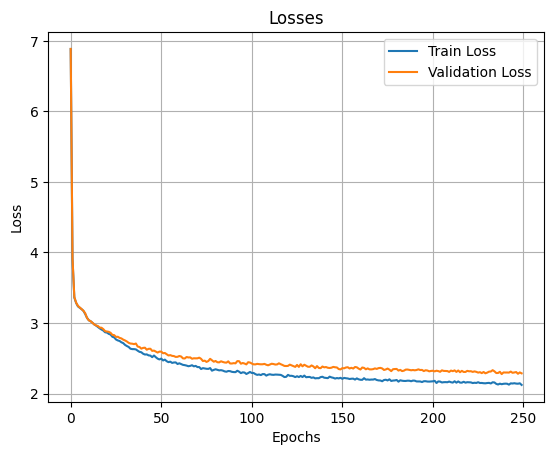

In [ ]:
losses= pd.DataFrame(losses)
plt.plot(losses['train'], label='Train Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.title('Losses')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()

**NOTE:** In this case, the x-axis stands for steps, not epochs.

The validation loss at the final step is 2.28 which is considered okay given the amount of training data we're using and the number of steps. To reduce the losses significantly, we will have to increase the size of the training data, higher number of steps and higher GPU or processing power.

# Inferencing our LLaMA 3 Model

Now that we've completed our training. Let's head into our final step: Inference and see how well the model generates the output texts given new input prompts.

In [ ]:
def sample_top_p(probs, p):
    """
    Perform top-p (nucleus) samplings on a probability distribution.
    - probs (torch.Tensor): Probability distribution tensor derived from the logits.
    - p: Probability threshold for top-p sampling.
    According to the paper, Top-p sampling selects the smallest set of tokens whose cumulative
    probability mass exceeds the threshold p. The distribution is renormalized based on the
    selected tokens.
    """
    probs_sort, prob_idx= torch.sort(probs, dim=-1, descending=True)
    probs_sum= torch.cumsum(probs_sort, dim=-1)
    mask= probs_sum - probs_sort > p
    probs_sort[mask]= 0.0
    probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))
    next_token= torch.multinomial(probs_sort, num_samples=1)
    next_token= torch.gather(prob_idx, -1, next_token)

    return next_token # sampled token indices from the vocabular


def generate(model, prompts, tk:Tokenizer, max_seq_len:int, max_gen_len:int=500,
             temperature:float=0.6, top_p:float=0.9):
    """
    This function generates text sequences based on provided prompts using the LLaMA 3 model
    we've built and trained.
    - prompts: List of user input texts or prompts.
    - max_gen_len: Maximum length of the generated text sequence.
    - temperature: Temperature value for controlling randomness in sampling. Default 0.6.
    - top_p: Top-p probability threshold for sampling prob output from the logits. Default 0.9.
    """
    bsz= 1 # for inferencing, in general user just input one prompt which we'll take it as 1-batch
    prompt_tokens= tk.token_bos.tolist() + tk.encode(prompts)
    assert len(prompt_tokens) <= max_seq_len, 'Prompt token length should be small than max_seq_len'
    total_len= min(len(prompt_tokens) + max_gen_len, max_seq_len)

    # this tokens matrix is to store the input prompts and all the output that is generated by the
    # model. later we'll use the tokenizer's decode function to decode this tokens to view results
    # in text format
    tokens= torch.full((bsz, total_len), fill_value=tk.token_pad.item(),
                       dtype=torch.long, device=next(model.parameters()).device)
    # fill in the prompt tokens into the token matrix
    tokens[:,:len(prompt_tokens)]= torch.tensor(
        prompt_tokens, dtype=torch.long, device=next(model.parameters()).device
    )
    #create a prompt_mask_token for later use to identify if the token is a prompt token or a
    # padding token
    # True if it is a prompt token, False if it is a padding token
    input_text_mask= tokens != tk.token_pad.item()

    # now we can start inferencing using one token at a time from the prompt_tokens list starting
    # with the first position
    prev_pos= 0
    for cur_pos in range(1, total_len):
        with torch.no_grad():
            model.train(False)
            logits, _= model(x=tokens[:,prev_pos:cur_pos], start_pos=prev_pos)
        if temperature> 0:
            probs= torch.softmax(logits[:, -1] / temperature, dim=-1)
            next_token= sample_top_p(probs, top_p)
        else:
            next_token= torch.argmax(logits[:, -1], dim=-1)

        next_token= next_token.reshape(-1)

        # only replace the token if it's a padding token
        next_token= torch.where(input_text_mask[:, cur_pos], tokens[:, cur_pos], next_token)
        tokens[:, cur_pos]= next_token

        prev_pos= cur_pos
        if tokens[:,cur_pos]== tk.token_pad.item() and next_token== tk.token_eos.item():
            break

    output_tokens, output_texts= [], []

    for i, toks in enumerate(tokens.tolist()):
        # eos_idx= toks.index(tk.token_eos.item())
        if tk.token_eos.item() in toks:
            eos_idx= toks.index(tk.token_eos.item())
            toks= toks[:eos_idx]

        output_tokens.append(toks)
        output_texts.append(tk.decode(toks))

    return output_tokens, output_texts


In [ ]:
# -- perform the inferencing on user input prompts --
prompts= "Consider you what services he has done"
output_tokens, output_texts= generate(model, prompts, tk, max_seq_len)
output_texts= output_texts[0].replace("<|begin_of_text|>", "")
print(output_texts)

Consider you what services he has done
eee hmrt u rtlnsal nw i a adiut
i o o uoet o o oter o aa i uee eee.
Pate o oftn eee h rsa ntsl?I o ad al od
hti o rbdts hml,bls hmrl o uoeo ade
h hssebe o ryan  o i atydl hv u rslns
 i a al  o hae ors o eee o o aete



we can see that our LLaMA 3 model is able to perform inference and generate texts on new prompts, though the output does not seem great given the amount of training data and steps we've used for training. I am sure with much larger training data, we'll achieve much better accuracy.

In [ ]:
# https://github.com/meta-llama/llama3/tree/main
# https://pub.towardsai.net/build-your-own-llama-3-architecture-from-scratch-using-pytorch-2ce1ecaa901c

# https://levelup.gitconnected.com/building-llama-3-from-scratch-with-python-e0cf4dbbc306#25b6

# How to Prune LLaMA 3.2
# https://towardsdatascience.com/how-to-prune-llama-3-2-and-similar-large-language-models-cf18e9a2afb6